In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install sentence-transformers

In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/UdS-DSAI/HLCV/project')

In [4]:
from datetime import datetime
import matplotlib.pyplot as plt
from dataloader_assg import  get_data_loader, get_query_image
from dataloader_coco import get_data_loader_train, get_data_loader_val
from visual_embedding import get_visual_embedding
from image_captioning import get_caption
from similarity_check import compute_similarity
from PIL import Image
from caption_embedding import sentenceEmbeddings
import numpy as np
import pandas as pd
import torch
import pickle
from tqdm import tqdm


%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/UdS-DSAI/HLCV/project/infersent_files/infersent2.pkl'

In [ ]:
# dataset_name = 'dataset3'
dataset_name = 'dataset3'

# cnn_model_name = "efficientnet" #resnet50 #efficientnet
# semantic_embeding_model = "universal_sent_encoder" #all-MiniLM-L6-v2 #universal_sent_encoder

cnn_model_name = "resnet50" #resnet50 #efficientnet
semantic_embeding_model = "all-MiniLM-L6-v2" #all-MiniLM-L6-v2 #universal_sent_encoder


data_dir = '/content/drive/MyDrive/UdS-DSAI/HLCV/project/{}'.format(dataset_name)
valid_dir = f'{data_dir}/valid/data'  # or 'val2017' for validation set
train_dir = f'{data_dir}/train/data'  # or 'val2017' for validation set
annotation_path_val = f'{data_dir}/valid/labels.json'



In [ ]:
import torch
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from pycocotools.coco import COCO
import PIL
import os


# Define the image pre-processing transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the desired size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])




# Custom dataset class
class CocoCustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_path,transform=None):
        self.coco = CocoDetection(root=image_dir, annFile=annotation_path, transform=transform)
        self.coco_annotation = COCO(annotation_file=annotation_path)
        self.image_dir = image_dir
        cat_ids = self.coco_annotation.getCatIds()
        self.cat_names =  self.coco_annotation.loadCats(cat_ids)
        self.transform = transform


    def __getitem__(self, index):

        # get img for CNN
        # img_vis, target = self.coco[index]
        img_vis, target = self.coco[index]

        #get img for captioning
        img_info = self.coco_annotation.loadImgs([index+1])[0]
        bbox_data = self.coco[index][1]

        # get largest bbox
        largest_bbox = None
        largest_area = 0

        for bbox in bbox_data:
          if bbox['area']>largest_area:
              largest_area = bbox['area']
              largest_bbox = bbox

        if largest_bbox is None:

          img_file_name = img_info["file_name"]
          img_cap = PIL.Image.open(os.path.join(self.image_dir, img_file_name)).convert("RGB")

          # get class labels
          class_labels = [int(x['category_id']) for x in target]
          class_labels = set(class_labels)
          class_names = [self.cat_names[i]["name"] for i in class_labels ]
          return img_vis,img_cap, class_names, img_file_name

        else:
          x, y, w, h = largest_bbox['bbox']
          x, y, w, h = int(x),int(y),int(w),int(h)

          img_file_name = img_info["file_name"]
          img_cap = PIL.Image.open(os.path.join(self.image_dir, img_file_name)).convert("RGB")

          img_cap = Image.fromarray(np.array(img_cap)[y:y+h, x:x+w])
          img_vis = self.transform(img_cap)

          # get class labels
          class_labels = [int(largest_bbox['category_id'])]
          class_labels = set(class_labels)
          class_names = [self.cat_names[i]["name"] for i in class_labels ]
          return img_vis,img_cap, class_names, img_file_name

    def __len__(self):
        return len(self.coco)



def get_data_loader_val(valid_dir,annotation_path_val,batch_size, shuffle):
    # Create the COCO custom dataset for validation set
    coco_dataset_val = CocoCustomDataset(valid_dir, annotation_path_val, transform=preprocess)
    data_loader_val = DataLoader(coco_dataset_val, batch_size=batch_size, shuffle=shuffle , collate_fn=lambda x: tuple(zip(*x)))
    return data_loader_val



In [ ]:
valid_batch_size = 1
data_loader_valid = get_data_loader_val(valid_dir,annotation_path_val, valid_batch_size, shuffle=False)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
# for i in list(data_loader_valid)[250]:
#   print(i)
#   pass
#   break

In [ ]:
# query_embeddings = []
# for vis_images, cap_images, targets, paths in tqdm(data_loader_valid):

#   if targets != []:
#     # print(paths)
#     # print(targets)
#     # get embeddings
#     images = torch.stack(list(vis_images), dim=0)
#     query_vis_embedding = get_visual_embedding(images, cnn_model_name)
#     query_caption = get_caption(cap_images)
#     query_cap_embeddings = sentenceEmbeddings(query_caption, semantic_embeding_model)
#     query_merged_embedding = np.concatenate((np.array(query_vis_embedding), query_cap_embeddings))

#     query_embeddings.append({
#       "image_filename" : paths[0],
#       "labels" : targets[0],
#       "caption" : query_caption[0],
#       "visual_embedding" : np.array(query_vis_embedding),
#       "caption_embedding" : np.array(query_cap_embeddings),
#       "merged_embedding" : np.array(query_merged_embedding) ,
#     })


In [ ]:
# query_embeddings[0]["merged_embedding"].shape

In [ ]:
query_dataset_path =\
 f"/content/drive/MyDrive/UdS-DSAI/HLCV/project/query_embeddings/query_embeddings_{dataset_name}_single_label_{cnn_model_name}_{semantic_embeding_model}.pkl"

print(query_dataset_path)


/content/drive/MyDrive/UdS-DSAI/HLCV/project/query_embeddings/query_embeddings_dataset3_single_label_resnet50_all-MiniLM-L6-v2.pkl


In [ ]:
# with open(query_dataset_path, "wb") as file:
#     pickle.dump(query_embeddings, file)

## Search Query and eval

In [ ]:
search_dataset_path =  f"/content/drive/MyDrive/UdS-DSAI/HLCV/project/dataset_embeddings/embeddings_{dataset_name}_{cnn_model_name}_{semantic_embeding_model}.pkl"

with open(search_dataset_path, "rb") as file:
    search_data = pickle.load(file)

# check dict
print(len(search_data))
print(len(search_data[0]))
print((search_data[0].keys()))
# print(data_from_file[0])



with open(query_dataset_path, "rb") as file:
    query_data = pickle.load(file)

# check dict
print(len(query_data))
print(len(query_data[0]))
print((query_data[0].keys()))
# print(data_from_file[0])



10000
6
dict_keys(['image_filename', 'labels', 'caption', 'visual_embedding', 'caption_embedding', 'merged_embedding'])
1000
6
dict_keys(['image_filename', 'labels', 'caption', 'visual_embedding', 'caption_embedding', 'merged_embedding'])


In [ ]:
search_df = pd.DataFrame(search_data)
search_df

,image_filename,labels,caption,visual_embedding,caption_embedding,merged_embedding
0,000000000009.jpg,"[orange, bowl, broccoli]",a lunch box filled with different types of food,"[0.13963033, 0.8087501, 0.13341343, 0.41564512...","[0.025212111, 0.059130102, 0.05020296, 0.05948...","[0.13963033, 0.8087501, 0.13341343, 0.41564512..."
1,000000000025.jpg,[giraffe],a giraffe standing next to a tree in a field,"[0.0057739313, 0.48521325, 0.08453734, 0.10147...","[-0.019110397, 0.11850104, -0.029063946, 0.000...","[0.0057739313, 0.48521325, 0.08453734, 0.10147..."
2,000000000030.jpg,"[potted plant, vase]",a white vase with flowers in it,"[0.26073873, 0.09454982, 1.1085361, 0.10515114...","[0.017984854, 0.07373421, 0.030602107, -0.0174...","[0.26073873, 0.09454982, 1.1085361, 0.10515114..."
3,000000000034.jpg,[zebra],a zebra grazing in a grassy field,"[0.40670353, 0.4646449, 0.20312008, 0.28817904...","[-0.019226711, 0.04762485, 0.038199574, -0.024...","[0.40670353, 0.4646449, 0.20312008, 0.28817904..."
4,000000000036.jpg,"[person, umbrella]",a woman holding a pink umbrella standing in fr...,"[0.29474398, 0.6572339, 0.6184481, 0.18362992,...","[0.027671611, 0.037935317, 0.027096855, 0.0171...","[0.29474398, 0.6572339, 0.6184481, 0.18362992,..."
...,...,...,...,...,...,...
9995,000000048784.jpg,[bus],a yellow school bus parked on the side of a road,"[0.50212014, 0.9453234, 0.18226153, 0.23190086...","[-0.029635036, 0.09362566, 0.024641184, 0.0194...","[0.50212014, 0.9453234, 0.18226153, 0.23190086..."
9996,000000048786.jpg,"[person, car, motorcycle]",a motorcycle is driving down the road,"[0.041859217, 0.4466581, 0.18942603, 0.6686684...","[-0.024784246, 0.07516569, 0.012310004, -0.013...","[0.041859217, 0.4466581, 0.18942603, 0.6686684..."
9997,000000048789.jpg,"[person, baseball bat, baseball glove, sports ...",a baseball player swinging a bat at a ball,"[0.27953005, 1.3035147, 0.98310083, 0.5544296,...","[0.07120451, 0.107586056, -0.03470545, -0.0108...","[0.27953005, 1.3035147, 0.98310083, 0.5544296,..."
9998,000000048791.jpg,"[person, giraffe]",a woman holding a giraffe in front of a fence,"[0.1969297, 0.23437041, 1.105127, 0.18671228, ...","[-0.03724143, 0.048921816, -0.012621341, 0.029...","[0.1969297, 0.23437041, 1.105127, 0.18671228, ..."


In [ ]:
query_df = pd.DataFrame(query_data)
query_df

,image_filename,labels,caption,visual_embedding,caption_embedding,merged_embedding
0,000000000139.jpg,[tv],a person standing in front of a tv,"[0.19238013, 0.3246456, 0.083277516, 0.2503702...","[0.002383098, 0.039429277, -0.014492446, -0.12...","[0.19238013, 0.3246456, 0.083277516, 0.2503702..."
1,000000000285.jpg,[bear],a brown bear is standing in the grass,"[0.1472939, 0.4675921, 0.0771915, 0.58238125, ...","[0.0064374753, 0.058891974, 0.026689587, -0.02...","[0.1472939, 0.4675921, 0.0771915, 0.58238125, ..."
2,000000000632.jpg,[bed],a bed with a blue blanket and a blue comforter,"[0.009661909, 0.96774465, 0.09533897, 0.308274...","[-0.049830295, 0.0015239416, 0.0047922204, 0.0...","[0.009661909, 0.96774465, 0.09533897, 0.308274..."
3,000000000724.jpg,[stop sign],a stop sign with a sticker on it,"[0.21466094, 3.8384116, 0.17631888, 0.35172513...","[-0.04136256, 0.030746922, 0.020953232, -0.011...","[0.21466094, 3.8384116, 0.17631888, 0.35172513..."
4,000000000776.jpg,[bed],a large group of teddy bears sitting on a bed,"[0.0014182125, 0.82516277, 0.11211588, 0.57113...","[0.05654418, -0.047416966, 0.042986427, 0.0763...","[0.0014182125, 0.82516277, 0.11211588, 0.57113..."
...,...,...,...,...,...,...
995,000000118594.jpg,[cow],a large cow standing in a field with a wire fe...,"[0.090633586, 0.2476974, 0.29737994, 0.2444780...","[0.025380615, 0.036762197, -0.037284125, -0.01...","[0.090633586, 0.2476974, 0.29737994, 0.2444780..."
996,000000118921.jpg,[person],a woman in a red jacket skiing down a hill,"[0.27528852, 0.34632704, 0.19685364, 0.381309,...","[-0.10225242, 0.042748667, -0.0153673, 0.00323...","[0.27528852, 0.34632704, 0.19685364, 0.381309,..."
997,000000119038.jpg,[cow],a herd of cattle standing on top of a lush gre...,"[0.47065306, 0.41213986, 0.454862, 0.098937266...","[0.014797503, -0.0068501933, 0.020714205, -0.0...","[0.47065306, 0.41213986, 0.454862, 0.098937266..."
998,000000119088.jpg,[person],a man in a wet suit is standing in the water,"[0.09584221, 0.8089246, 0.12619968, 0.36109567...","[0.012126339, 0.06093509, 0.024486296, -0.0285...","[0.09584221, 0.8089246, 0.12619968, 0.36109567..."


In [ ]:
def norm_embedding(x):
  return  (x-np.min(x))/(np.max(x)-np.min(x))


In [ ]:
search_df['norm_visual_embedding'] = search_df.apply(lambda x: norm_embedding(x['visual_embedding']), axis=1)
search_df['norm_caption_embedding'] = search_df.apply(lambda x: norm_embedding(x['caption_embedding']), axis=1)
search_df['merged_normed_embedding'] = search_df.apply(lambda x: norm_embedding(x['merged_embedding']), axis=1)
search_df['norm_merged_embedding'] = search_df.apply(lambda x: np.concatenate((x['norm_visual_embedding'],x['norm_caption_embedding'])), axis=1)

query_df['norm_visual_embedding'] = query_df.apply(lambda x: norm_embedding(x['visual_embedding']), axis=1)
query_df['norm_caption_embedding'] = query_df.apply(lambda x: norm_embedding(x['caption_embedding']), axis=1)
query_df['merged_normed_embedding'] = query_df.apply(lambda x: norm_embedding(x['merged_embedding']), axis=1)
query_df['norm_merged_embedding'] = query_df.apply(lambda x: np.concatenate((x['norm_visual_embedding'],x['norm_caption_embedding'])), axis=1)



In [ ]:
query_df.columns

Index(['image_filename', 'labels', 'caption', 'visual_embedding',
       'caption_embedding', 'merged_embedding', 'norm_visual_embedding',
       'norm_caption_embedding', 'merged_normed_embedding',
       'norm_merged_embedding'],
      dtype='object')

In [ ]:
query_dict = query_df.to_dict(orient="records")

In [ ]:
def get_match_info(top_k_similar):
  match_info = []
  for embedding, similarity,idx in top_k_similar:
    match_info.append({
        "match_score":similarity,
        "match_filename":search_df['image_filename'][idx],
        "match_labels":search_df['labels'][idx],
        "match_caption":search_df['caption'][idx]
    })

  return match_info

In [ ]:
# match_results = []
# cnt=0
# for query in tqdm(query_dict):

#   visual_topk = compute_similarity(query["visual_embedding"], list(search_df['visual_embedding']), similarity_metric='cosine')
#   caption_topk = compute_similarity(query["caption_embedding"], list(search_df['caption_embedding']), similarity_metric='cosine')
#   norm_visual_topk = compute_similarity(query["norm_visual_embedding"], list(search_df['norm_visual_embedding']), similarity_metric='cosine')
#   norm_caption_topk = compute_similarity(query["norm_caption_embedding"], list(search_df['norm_caption_embedding']), similarity_metric='cosine')

#   merged_topk = compute_similarity(query["merged_embedding"], list(search_df['merged_embedding']), similarity_metric='cosine')
#   norm_merged_topk = compute_similarity(query["norm_merged_embedding"], list(search_df['norm_merged_embedding']), similarity_metric='cosine')
#   merged_normed_topk = compute_similarity(query["merged_normed_embedding"], list(search_df['merged_normed_embedding']), similarity_metric='cosine')

#   #save results
#   result  = {
#     'image_filename':query["image_filename"],
#     'labels' : query['labels'],
#     'caption': query['caption']
#   }

#   result["visual_topk"] = get_match_info(visual_topk)
#   result["caption_topk"] = get_match_info(caption_topk)
#   result["norm_visual_topk"] = get_match_info(norm_visual_topk)
#   result["norm_caption_topk"] = get_match_info(norm_caption_topk)

#   result["merged_topk"] = get_match_info(merged_topk)
#   result["norm_merged_topk"] = get_match_info(norm_merged_topk)
#   result["merged_normed_topk"] = get_match_info(merged_normed_topk)

#   match_results.append(result)

#   cnt+=1
#   if cnt==100:
#     break
# print(len(match_results))

In [ ]:
# no = 2
search_result_path =\
 f"/content/drive/MyDrive/UdS-DSAI/HLCV/project/results/match_results_single_label_{dataset_name}_{cnn_model_name}_{semantic_embeding_model}.pkl"

print(search_result_path)

/content/drive/MyDrive/UdS-DSAI/HLCV/project/results/match_results_single_label_dataset3_resnet50_all-MiniLM-L6-v2.pkl


In [ ]:
# with open(search_result_path, "wb") as file:
#     pickle.dump(match_results, file)

## evals

In [ ]:
with open(search_result_path, "rb") as file:
    data_from_file = pickle.load(file)


In [ ]:
data_from_file[0]["norm_visual_topk"][0].keys()

dict_keys(['match_score', 'match_filename', 'match_labels', 'match_caption'])

In [ ]:
def show_topk(data,topk_type,thresh):

  # f,axs=plt.subplots(1,k+1,figsize=(20,20)) #ROW,COLUMN
  # axs[0].imshow(plt.imread(valid_dir+"/"+data["image_filename"]))
  # axs[0].title.set_text("Query Img - "+topk_type)
  target_labels = data["labels"]
  tp = 0
  fp = 0
  tn = 0
  fn = 0

  for i,topk in enumerate(data[topk_type]):
    if topk["match_labels"] != []:

      if topk["match_score"] > thresh or topk["match_score"] == thresh : #POSITIVE
      # axs[i+1].imshow(plt.imread(train_dir+"/"+topk["match_filename"]))
        if target_labels[0] == topk["match_labels"][0]:
            tp += 1
        else:
            fp += 1

      else: #NEGATIVE
        if target_labels[0] == topk["match_labels"][0]:
            fn += 1
        else:
            tn += 1
      err = 0.0000001
      prec = tp / (tp+fp  + err)
      rec = tp / (tp+fn + err)


  return prec, rec


In [ ]:
visual_pr, caption_pr, merged_pr, norm_merged_pr, merged_normed_pr = [],[],[],[],[]
visual_rec, caption_rec, merged_rec, norm_merged_rec, merged_normed_rec = [],[],[],[],[]

thresh = 0.83
query_set = data_from_file
for  data in tqdm(query_set):

  # print('===============  {}  ====================='.format(idx))

  target_labels = data["labels"][0]
  target_caption = data["caption"]

  # print(target_labels)
  # print(target_caption)

  visual = show_topk(data,"visual_topk",thresh)
  caption = show_topk(data,"caption_topk",thresh)
  merged = show_topk(data,"merged_topk",thresh)
  norm_merged = show_topk(data,"norm_merged_topk",thresh)
  merged_normed = show_topk(data,"merged_normed_topk",thresh)

  visual_pr.append(visual[0])
  caption_pr.append(caption[0])
  merged_pr.append(merged[0])
  norm_merged_pr.append(norm_merged[0])
  merged_normed_pr.append(merged_normed[0])

  visual_rec.append(visual[1])
  caption_rec.append(caption[1])
  merged_rec.append(merged[1])
  norm_merged_rec.append(norm_merged[1])
  merged_normed_rec.append(merged_normed[1])




100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


In [ ]:
visual_pr_avg = sum(visual_pr)/len(visual_pr)
caption_pr_avg = sum(caption_pr)/len(caption_pr)
merged_pr_avg = sum(merged_pr)/len(merged_pr)
norm_merged_pr_avg = sum(norm_merged_pr)/len(norm_merged_pr)
merged_normed_pr_avg = sum(merged_normed_pr)/len(merged_normed_pr)

visual_rec_avg = sum(visual_rec)/len(visual_rec)
caption_rec_avg = sum(caption_rec)/len(caption_rec)
merged_rec_avg = sum(merged_rec)/len(merged_rec)
norm_merged_rec_avg = sum(norm_merged_rec)/len(norm_merged_rec)
merged_normed_rec_avg = sum(merged_normed_rec)/len(merged_normed_rec)

In [ ]:
print("visual embedding model : {}".format(cnn_model_name))
print("semantic_embeding_model : {}".format(semantic_embeding_model))

eval_results  = [
    {"match_type":"visual","Average Precision":visual_pr_avg,"Average Recall":visual_rec_avg},
    {"match_type":"caption","Average Precision":caption_pr_avg,"Average Recall":caption_rec_avg},
    {"match_type":"merged","Average Precision":merged_pr_avg,"Average Recall":merged_rec_avg},
    {"match_type":"norm_merged","Average Precision":norm_merged_pr_avg,"Average Recall":norm_merged_rec_avg},
    {"match_type":"merged_normed","Average Precision":merged_normed_pr_avg,"Average Recall":merged_normed_rec_avg},

    ]
eval_results_df = pd.DataFrame(eval_results)
eval_results_df

visual embedding model : resnet50
semantic_embeding_model : all-MiniLM-L6-v2


,match_type,Average Precision,Average Recall
0,visual,0.282582,0.025605
1,caption,0.456382,0.027589
2,merged,0.282634,0.025329
3,norm_merged,0.279086,0.541849
4,merged_normed,0.409794,0.121776


## Precision Recall Curve


In [ ]:
visual_pr_avg_list = []
caption_pr_avg_list = []
merged_pr_avg_list = []
norm_merged_pr_avg_list = []
merged_normed_pr_avg_list = []

visual_rec_avg_list = []
caption_rec_avg_list = []
merged_rec_avg_list = []
norm_merged_rec_avg_list = []
merged_normed_rec_avg_list = []

threshs = np.arange(0,1,0.05)
for t in tqdm(threshs):
  visual_pr, caption_pr, merged_pr, norm_merged_pr, merged_normed_pr = [],[],[],[],[]
  visual_rec, caption_rec, merged_rec, norm_merged_rec, merged_normed_rec = [],[],[],[],[]

  query_set = data_from_file
  for  data in query_set:

    # print('===============  {}  ====================='.format(idx))

    target_labels = data["labels"][0]
    target_caption = data["caption"]

    # print(target_labels)
    # print(target_caption)

    visual = show_topk(data,"visual_topk",t)
    caption = show_topk(data,"caption_topk",t)
    merged = show_topk(data,"merged_topk",t)
    norm_merged = show_topk(data,"norm_merged_topk",t)
    merged_normed = show_topk(data,"merged_normed_topk",t)

    visual_pr.append(visual[0])
    caption_pr.append(caption[0])
    merged_pr.append(merged[0])
    norm_merged_pr.append(norm_merged[0])
    merged_normed_pr.append(merged_normed[0])

    visual_rec.append(visual[1])
    caption_rec.append(caption[1])
    merged_rec.append(merged[1])
    norm_merged_rec.append(norm_merged[1])
    merged_normed_rec.append(merged_normed[1])

  visual_pr_avg_list.append(sum(visual_pr)/len(visual_pr))
  caption_pr_avg_list.append(sum(caption_pr)/len(caption_pr))
  merged_pr_avg_list.append(sum(merged_pr)/len(merged_pr))
  norm_merged_pr_avg_list.append(sum(norm_merged_pr)/len(norm_merged_pr))
  merged_normed_pr_avg_list.append(sum(merged_normed_pr)/len(merged_normed_pr))

  visual_rec_avg_list.append(sum(visual_rec)/len(visual_rec))
  caption_rec_avg_list.append(sum(caption_rec)/len(caption_rec))
  merged_rec_avg_list.append(sum(merged_rec)/len(merged_rec))
  norm_merged_rec_avg_list.append(sum(norm_merged_rec)/len(norm_merged_rec))
  merged_normed_rec_avg_list.append(sum(merged_normed_rec)/len(merged_normed_rec))




100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


Text(0.5, 1.0, 'Precision Recall Curve (Resnet50, Sentence Transformer )')

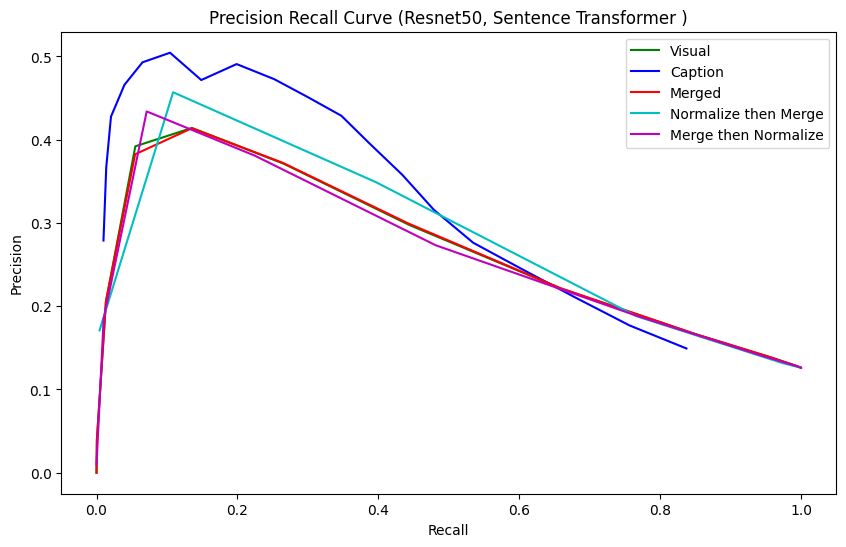

In [ ]:

plt.figure(figsize=(10,6))
# plt.plot(threshs, , 'b.-')
plt.plot(visual_rec_avg_list[1:],visual_pr_avg_list[1:], 'g-')
plt.plot(caption_rec_avg_list[1:],caption_pr_avg_list[1:], 'b-')
plt.plot(merged_rec_avg_list[1:],merged_pr_avg_list[1:], 'r-')
plt.plot(norm_merged_rec_avg_list[1:],norm_merged_pr_avg_list[1:], 'c-')
plt.plot(merged_normed_rec_avg_list[1:],merged_normed_pr_avg_list[1:], 'm-')
plt.legend( ('Visual', 'Caption', 'Merged','Normalize then Merge','Merge then Normalize'))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve (Resnet50, Sentence Transformer )")
# plt.title("Precision Recall Curve (EfficientNet, Universal Sentence Encoder)")


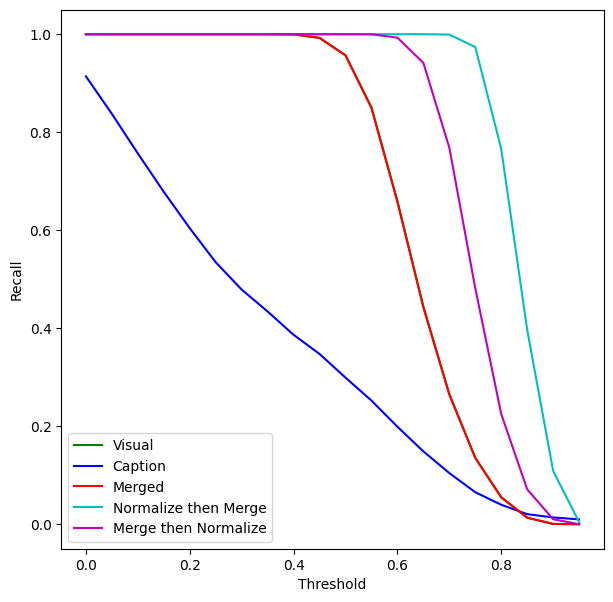

In [ ]:

plt.figure(figsize=(7,7))
# plt.plot(threshs, , 'b.-')
plt.plot(threshs,visual_rec_avg_list, 'g-')
plt.plot(threshs,caption_rec_avg_list, 'b-')
plt.plot(threshs,merged_rec_avg_list, 'r-')
plt.plot(threshs,norm_merged_rec_avg_list, 'c-')
plt.plot(threshs,merged_normed_rec_avg_list, 'm-')
plt.legend( ('Visual', 'Caption', 'Merged','Normalize then Merge','Merge then Normalize'))
# plt.title("Recall  Curve (Resnet50, Sentence Transformer )")
# plt.title("Recall  Curve (EfficientNet, Universal Sentence Encoder)")
plt.ylabel("Recall")
plt.xlabel("Threshold")
plt.show()

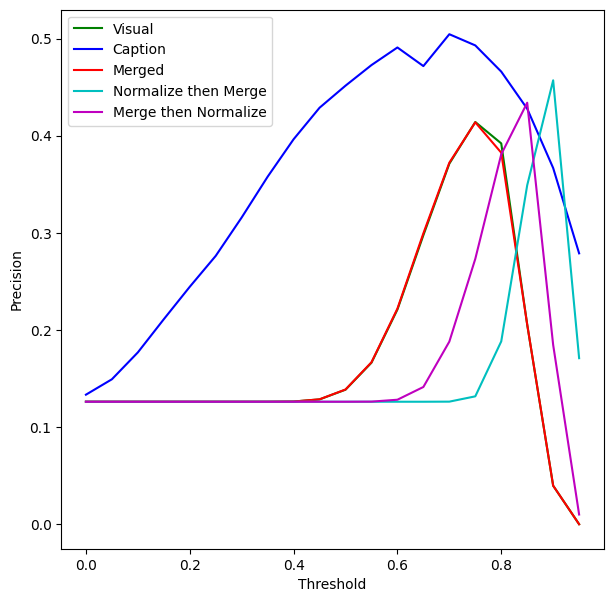

In [ ]:

plt.figure(figsize=(7,7))
# plt.plot(threshs, , 'b.-')
plt.plot(threshs,visual_pr_avg_list, 'g-')
plt.plot(threshs,caption_pr_avg_list, 'b-')
plt.plot(threshs,merged_pr_avg_list, 'r-')
plt.plot(threshs,norm_merged_pr_avg_list, 'c-')
plt.plot(threshs,merged_normed_pr_avg_list, 'm-')
plt.legend( ('Visual', 'Caption', 'Merged','Normalize then Merge','Merge then Normalize'))
# plt.title("Precision  Curve (Resnet50, Sentence Transformer )")
# plt.title("Precision  Curve (EfficientNet, Universal Sentence Encoder)")

plt.ylabel("Precision")
plt.xlabel("Threshold")
plt.show()